## Set to directory with python scripts

In [1]:
scripts_path = '/Users/jendawk/Dropbox (MIT)/C Diff Recurrence Paper/Analyses/scripts/'

# Path to save figures
path_to_save = '/'.join(scripts_path.split('/')[:-2]) + '/'

# Path to save supplementary and figure data folders
save_path = '/Users/jendawk/Dropbox (MIT)/C Diff Recurrence Paper/'
%cd $scripts_path

/Users/jendawk/Dropbox (MIT)/C Diff Recurrence Paper/Analyses/scripts


## Load modules

In [2]:
import scipy.stats as st
from collections import Counter
import sklearn
from matplotlib import cm
import scipy
import  itertools
from datetime import datetime
from seaborn import clustermap
from scipy.cluster.hierarchy import linkage
from sklearn.linear_model import LogisticRegression
import os
import time
import pickle as pkl
import pandas as pd
from dataLoader import *
from basic_data_methods_helper import *
from skbio.stats.distance import permanova, DistanceMatrix, anosim
from skbio.stats.distance import mantel
from statsmodels.stats.multitest import multipletests
from matplotlib.collections import LineCollection
from Bio import Phylo
import re
from statistics import mode
import seaborn as sns
from sksurv.linear_model import CoxnetSurvivalAnalysis, CoxPHSurvivalAnalysis
from sksurv.metrics import concordance_index_censored
import matplotlib.lines as mlines
import seaborn as sns
from skbio.diversity.alpha import chao1
from make_heatmaps import *

# Set font for figures
from matplotlib import rc
rc('font',**{'family':'sans-serif','sans-serif':['Arial']})

## Load data

In [3]:
# set data_path to point to directory with data
data_path = scripts_path + 'inputs/'

# Option to change filtering criteria
dl = dataLoader(path = data_path, pt_perc = {'metabs': .25, '16s': .1, 'scfa': 0, 'toxin':0}, meas_thresh = 
                {'metabs': 0, '16s': 10, 'scfa': 0, 'toxin':0}, 
                var_perc = {'metabs': 50, '16s': 5, 'scfa': 0, 'toxin':0}, pt_tmpts = 1)

No patient demographic/clinical data available due to identifiability


# Figure 2 - heatmaps

### Find ASVs & metabolites w/ FDR < 0.05

In [4]:
path_univariate = path_to_save + 'univariate_analysis_control/'

feats_dict_sm = {}
# feats_dict_labels = {}
for dtype in ['16s','metabs']:
    feats = []
    imp_feats = []
    print(dtype)
    univariate = path_to_save + 'univariate_analysis_control/'
    for file in os.listdir(univariate + dtype):
        if '.csv' not in file or 'ecurrer' in file:
            continue
        if dtype == '16s' and 'deseq2' not in file:
            continue
        pvals = pd.read_csv(path_univariate + dtype + '/' + file, index_col = [0])
        if 'padj' in pvals.columns.values:
            pa = 'padj'
        else:
            pa = 'FDR, Outcome'
        p_imp = pvals.index.values[pvals[pa]<=0.05]
        imp_feats.extend(p_imp)
        if dtype == 'metabs':
            print(file)
            print(imp_feats)

    feats_dict_sm[dtype] = np.unique(imp_feats)
    print(len(np.unique(imp_feats)))
    print('')

16s
51

metabs
OLS_metabs1.csv
['vanillylmandelate (VMA)']
OLS_metabs0.csv
['vanillylmandelate (VMA)']
OLS_metabs2.csv
['vanillylmandelate (VMA)', '1-palmitoyl-2-stearoyl-GPC (16:0/18:0)', '11beta-hydroxyetiocholanolone glucuronide*', "6'-sialyllactose", 'apigenin sulfate (1)', 'behenoyl ethanolamide (22:0)*', 'behenoyl sphingomyelin (d18:1/22:0)*', 'D-urobilin', 'estrone 3-sulfate', 'etiocholanolone glucuronide', 'glucuronide of piperine metabolite C17H21NO3 (1)*', 'glucuronide of piperine metabolite C17H21NO3 (4)*', 'glucuronide of piperine metabolite C17H21NO3 (6)*', 'lignoceroyl ethanolamide (24:0)*', 'lignoceroyl sphingomyelin (d18:1/24:0)', 'pregnanediol-3-glucuronide', 'salicyluric glucuronide*', 'sphingomyelin (d18:1/20:0, d16:1/22:0)*', 'sphingomyelin (d18:2/24:1, d18:1/24:2)*', 'taurochenodeoxycholic acid 3-sulfate', 'taurohyocholate*', 'tetrahydrocorticosterone glucuronide']
22



### Export ASVs to run phylogenic placement scripts

In [8]:
# Export filtered taxa names to make tree with only query reads
taxa_labels = pd.read_csv(path_to_save + 'scripts/inputs/' + 'taxa_labels.csv', index_col = [0])

for i,seq in enumerate(feats_dict_sm['16s']):
    if i ==0:
        wa = 'w'
    else:
        wa = 'a'
    
    f = open("phylo_placement_ap19/data/asvs_to_place.txt", wa)
    f.writelines('>' + taxa_labels.loc[seq]['labels'] + '\n' + seq+ '\n')
    f.close()
    
    
    f = open("phylo_placement_ap19/data/asvs_to_place.fa", wa)
    f.writelines('>' + taxa_labels.loc[seq]['labels'] + '\n' + seq + '\n')
    f.close()

### ratios of each data source for plotting

In [5]:
ratios = {}
for key in 'metabs', '16s', 'scfa':
    data, _ = get_data(key, dl, dtype = 'filtered_data')
    total = data.shape[0]
    ratios[key] = {}
    for week in [0,1,2]:
        data, _ = get_data(key, dl, week = week, dtype = 'filtered_data')
        ratios[key][week] = (data.shape[0]/total)*14

## Plot ASVs

font: 10.0
axes_title: 10.0
axes_label: 10.0
xtick_label: 8.5
ytick_label: 8.0
legend: 10.0
figure_title: 12.0


/Users/jendawk/miniconda3/envs/CodeBase/lib/python3.7/site-packages/pandas/core/computation/expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
/Users/jendawk/miniconda3/envs/CodeBase/lib/python3.7/site-packages/pandas/core/computation/expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
/Users/jendawk/miniconda3/envs/CodeBase/lib/python3.7/site-packages/pandas/core/computation/expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
/Users/jendawk/miniconda3/envs/CodeBase/lib/python3.7/site-packages/pandas/core/computation/expre

font: 4.5
font: 8.0


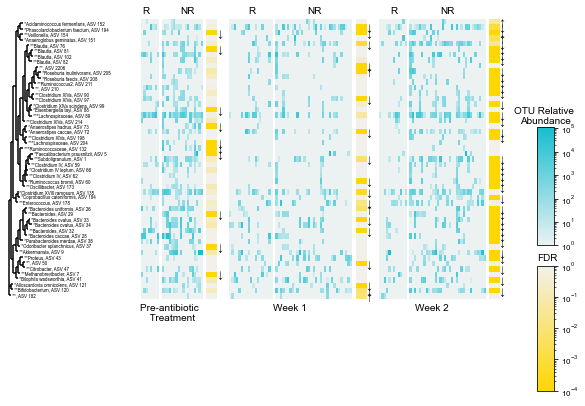

In [6]:
fig, ax = plt.subplots(1,10, gridspec_kw = {'width_ratios':[2,4,ratios['16s'][0],0.5,0.15,
                                                           ratios['16s'][1],0.5,0.15,ratios['16s'][2],0.5]}, 
                       figsize = (7.5,4.6875),
                      constrained_layout = False)

set_font_sizes(None, {'font': 10, 'axes_title': 10, 'axes_label': 10, 
                                          'xtick_label': 8.5, 'ytick_label': 8, 
                         'legend': 10, 'figure_title': 12})

ax_otus = ax[[2,5,8]]
ax_phylo = ax[0]
ax_side = ax[[3,6,9]]
ax_inv_bw = ax[[1,4,7]]

for axx in ax_inv_bw:
    axx.set_visible(False)

path = 'phylo_placement_ap19/'
with open(path + 'data/asvs_to_place.txt') as file:  
    data = file.read().splitlines()

otus = data[::2]
seqs = data[1::2]

# dat = get_data('16s', dtype = 'filtered_data')[0]
# seqs = list(set(seqs).intersection(set(dat.columns.values)))

taxdat_silva = pd.read_csv('inputs/dada2-taxonomy-silva.csv')
taxdat_rdp = pd.read_csv('inputs/dada2-taxonomy-rdp.csv')

otu_dict = {}
for i, otu in enumerate(otus):
    if i >= len(seqs):
        break
    otu_dict[otu.split('>')[1]]={}
    otu_dict[otu.split('>')[1]]['seq'] = seqs[i]
#     otu_dict[otu.split('>')[1]]['tax'] = taxdat['genus_species'].loc[seqs[i]]
    
    otu_dict[otu.split('>')[1]]['tax'] = ' '.join(taxdat_rdp[seqs[i]][-2:].dropna())
#     otu_dict[otu.split('>')[1]]['tax'] = ''

seq_to_otu = {seq['seq']: otu for otu, seq in otu_dict.items()}
tree = Phylo.read(path + 'output/newick_tree_query_reads.nhx','newick')
clades = tree.get_terminals(order = 'preorder')
otu_order = [c.name for c in clades]
names = lookup_by_names(tree, otu_dict, seq_to_otu, path_to_save + 'univariate_analysis_control/', branch_len = 0.01)

seq_order = [otu_dict[od]['seq'] for od in otu_order]
fig, ax_otus, ax_side, right, pos = plot_heatmap(
    '16s', seq_order, fig, ax_otus, 
    ax_side, dl,dtype = 'data', cmap_heat = 'tab:cyan',
    cmap_sig = 'gold', 
    path_to_univariate_analysis = '/Users/jendawk/Dropbox (MIT)/C Diff Recurrence Paper/Analyses/univariate_analysis_control/',
    path_to_save_data = '/Users/jendawk/Dropbox (MIT)/C Diff Recurrence Paper/Rebuttal 2/GenFigure&AnalysesData/')

# ax_otus[0].axes.get_yaxis().set_visible(True)
# ax_otus[0].set_yticks(np.arange(len(seq_order)))
# ax_otus[0].set_yticklabels([otu_dict[otu]['tax'] for otu in otu_order], fontsize = 10)
                      
ax_phylo.set_frame_on(False)
ax_phylo.axes.get_yaxis().set_visible(False)
ax_phylo.axes.get_xaxis().set_visible(False)
set_font_sizes(None, {'font': 4.5})
Phylo.draw(tree, axes = ax_phylo,do_show=False)

set_font_sizes(None, {'font': 8})
arr_x = 0.96
arr_y = 0.08
cbaxes = fig.add_axes([arr_x + .08, -.17, 0.032, 0.37]) 
cbaxes.set_xlabel('FDR', labelpad = 5, loc = 'left')
cb = fig.colorbar(right, cax = cbaxes)
# cbaxes.set_yticklabels([r'$10^{-24}$',r'$10^{-18}$',r'$10^{-12}$',r'$10^{-6}$','1'])
cbaxes.xaxis.set_label_position('top')

cbaxes2 = fig.add_axes([arr_x + 0.08, 0.26, 0.032, 0.35]) 
cb2 = fig.colorbar(pos, cax = cbaxes2)
cbaxes2.set_xlabel('OTU Relative \nAbundance', loc = 'center')
# cbaxes2.set_yticklabels([0,10,r'$10^{2}$',r'$10^{3}$',r'$10^{4}$'])
cbaxes2.xaxis.set_label_position('top')


fig.savefig(path_to_save + 'output_figures/Fig3/otus_005.pdf',bbox_inches='tight')

## Plot metabolites

font: 10.0
axes_title: 10.0
axes_label: 10.0
xtick_label: 8.5
ytick_label: 8.0
legend: 10.0
figure_title: 12.0
0.5
2.0
5.5
9.0
10.5
13.0
15.5
16.5
19.0
21.5


/Users/jendawk/miniconda3/envs/CodeBase/lib/python3.7/site-packages/pandas/core/computation/expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
/Users/jendawk/miniconda3/envs/CodeBase/lib/python3.7/site-packages/pandas/core/computation/expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
/Users/jendawk/miniconda3/envs/CodeBase/lib/python3.7/site-packages/pandas/core/computation/expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
/Users/jendawk/miniconda3/envs/CodeBase/lib/python3.7/site-packages/pandas/core/computation/expre

font: 4.5
font: 8.0


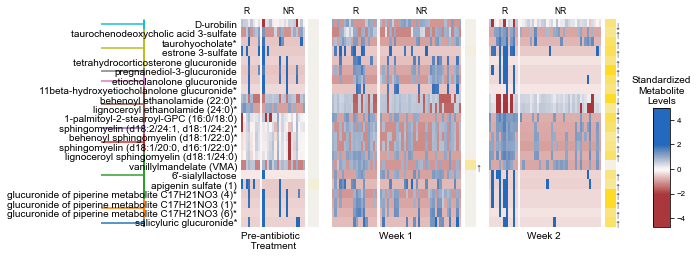

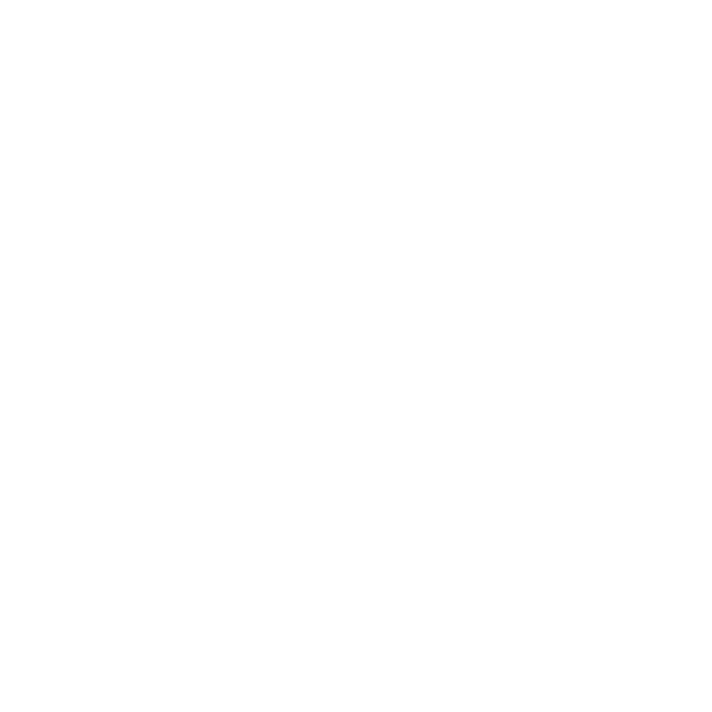

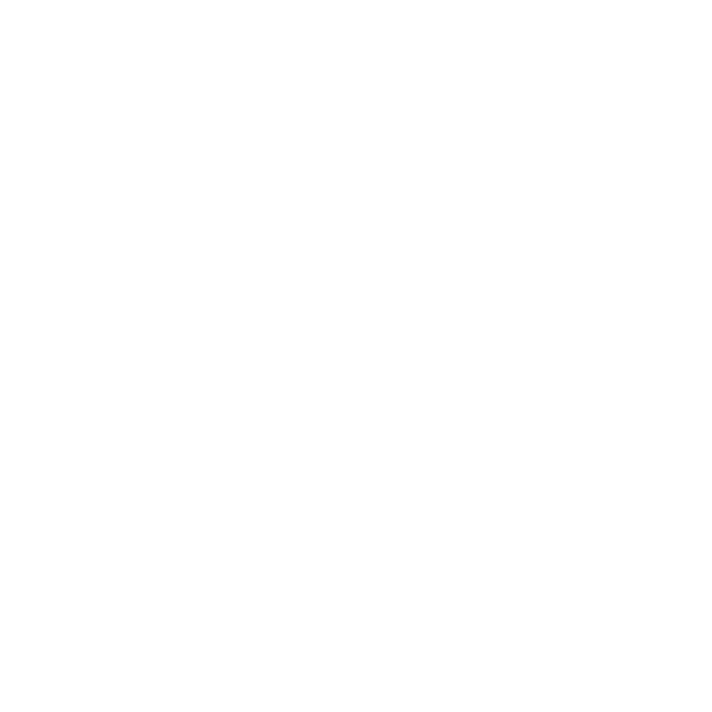

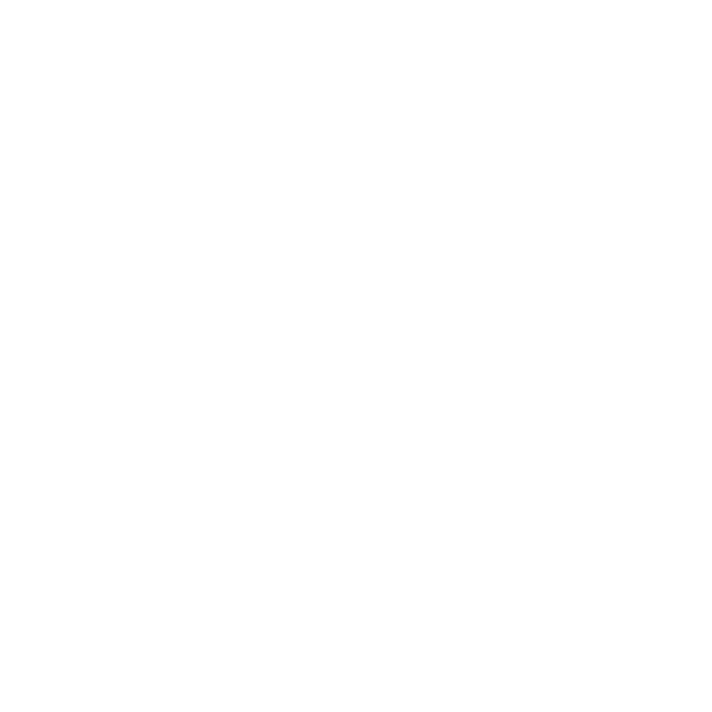

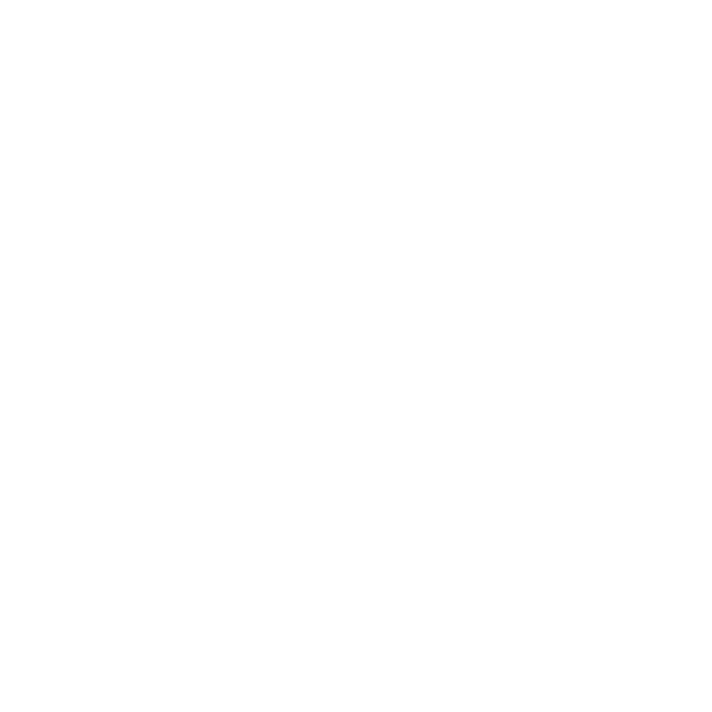

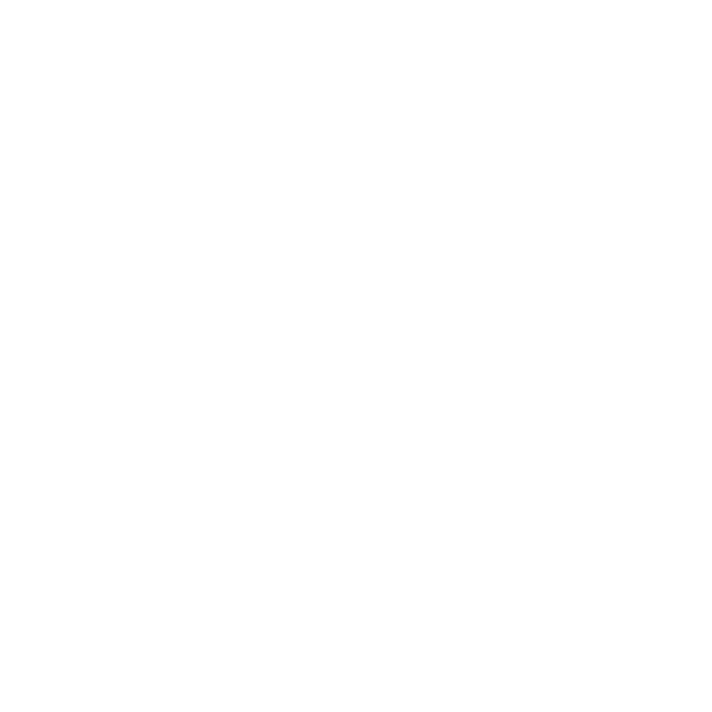

In [8]:
fig, ax = plt.subplots(1,10, gridspec_kw = {'width_ratios':[2,4,ratios['metabs'][0],0.5,0.15,
                                                           ratios['metabs'][1],0.5,0.15,ratios['metabs'][2],0.5]}, 
                       figsize = (7.5,3.6875),
                      constrained_layout = False)

set_font_sizes(None, {'font': 10, 'axes_title': 10, 'axes_label': 10, 
                                          'xtick_label': 8.5, 'ytick_label': 8, 
                         'legend': 10, 'figure_title': 12})

# ax_metabs = ax[0,[1,3,5]]
# ax_dendro = ax[0,0]
# ax_top = ax[1,[1,3,5]]
# ax_side = ax[0,[2,4,6]]
# ax_inv = ax[1,[0,2,4,6]]

ax_metabs = ax[[2,5,8]]
ax_dendro = ax[0]
ax_side = ax[[3,6,9]]
ax_inv = ax[[0,1,3,6,9]]
ax_inv_bw = ax[[1,4,7]]

for axx in ax_inv_bw:
    axx.set_visible(False)


weeks = [0,1,2]

custom_order = ['Hemoglobin and Porphyrin Metabolism','Secondary Bile Acid Metabolism',
                ['Progestin Steroids','Estrogenic Steroids','Androgenic Steroids','Corticosteroids'],
                'Endocannabinoid',['Phosphatidylcholine (PC)','Lysophospholipid'],
                'Sphingomyelins','Tyrosine Metabolism','Carbohydrate','Food Component/Plant',
                ['Drug - Antibiotic','Drug - Analgesics, Anesthetics']]
# custom_order = np.flip(custom_order)

col_mat_df = dl.col_mat_mets
col_mat_sorted = col_mat_df.sort_values(by = ['SUPER_PATHWAY', 'SUB_PATHWAY'])
biochem_sorted = col_mat_sorted.index.values
df_dendro = col_mat_sorted[['SUPER_PATHWAY','SUB_PATHWAY']].astype('category')

# df_dendro = df_dendro.replace('Partially Characterized Molecules','Partially \nCharacterized \nMolecules')
# df_dendro = df_dendro.replace('Cofactors and Vitamins', 'Cofactors \nand \nVitamins')

dat, _ = get_data('metabs', dl, dtype = 'data', features = feats_dict_sm['metabs'])

fig, ax_dendro, order_dict, pathways = make_metab_dendrogram(df_dendro, dat, fig, ax_dendro, custom_order)
rownames = np.concatenate([order_dict[path] for path in pathways])
# rownames = np.flip(rownames)

# rownames = dat.columns.values
fig, ax_metabs, ax_side, right, pos = plot_heatmap('metabs', rownames, fig, ax_metabs, ax_side, dl,
                                                          cmap_heat = "vlag", cmap_sig = 'gold', 
                                                   path_to_univariate_analysis = '/Users/jendawk/Dropbox (MIT)/C Diff Recurrence Paper/Analyses/univariate_analysis_control/',
                                                  path_to_save_data = '/Users/jendawk/Dropbox (MIT)/C Diff Recurrence Paper/Rebuttal 2/GenFigure&AnalysesData/')
# df_side = make_side_heatmap('metabs', rownames, fig, ax_side_strip, 
#                             path_to_save, colormap = 'PRGn', plot_padj = True)

ax_metabs[0].axes.get_yaxis().set_visible(True)
set_font_sizes(None, {'font': 4.5})
ax_metabs[0].set_yticks(np.arange(len(rownames)))

# slab = get_rownames(rownames)
ax_metabs[0].set_yticklabels(rownames, fontsize = 10)
ax_metabs[0].tick_params('both', length=0, which='major')

ax_dendro.set_frame_on(False)
ax_dendro.axes.get_xaxis().set_visible(False)
ax_dendro.axes.get_yaxis().set_visible(False)

set_font_sizes(None, {'font': 8})
arr_x = 0.96
arr_y = 0.08
# cbaxes = fig.add_axes([arr_x + .08, -.2, 0.04, 0.45]) 
# cbaxes.set_xlabel('FDR', labelpad = 5, loc = 'left')
# cb = fig.colorbar(right, cax = cbaxes)
# # cbaxes.set_yticklabels([r'$10^{-24}$',r'$10^{-18}$',r'$10^{-12}$',r'$10^{-6}$','1'])
# cbaxes.xaxis.set_label_position('top')

cbaxes2 = fig.add_axes([arr_x + .081, 0.13, 0.032, 0.45]) 
cb2 = fig.colorbar(pos, cax = cbaxes2)
cbaxes2.set_xlabel('Standardized\nMetabolite\nLevels', loc = 'center')
# cbaxes2.set_yticklabels([0,10,r'$10^{2}$',r'$10^{3}$',r'$10^{4}$'])
cbaxes2.xaxis.set_label_position('top')

fig.savefig(path_to_save + 'output_figures/Fig3/metabs_sm_005.pdf',bbox_inches='tight')

## Plot SCFAs

font: 10.0
axes_title: 10.0
axes_label: 10.0
xtick_label: 8.5
ytick_label: 8.0
legend: 10.0
figure_title: 12.0


/Users/jendawk/miniconda3/envs/CodeBase/lib/python3.7/site-packages/pandas/core/computation/expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
/Users/jendawk/miniconda3/envs/CodeBase/lib/python3.7/site-packages/pandas/core/computation/expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
/Users/jendawk/miniconda3/envs/CodeBase/lib/python3.7/site-packages/pandas/core/computation/expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
/Users/jendawk/miniconda3/envs/CodeBase/lib/python3.7/site-packages/pandas/core/computation/expre

font: 11.666666666666668
ytick_label: 9.722222222222223


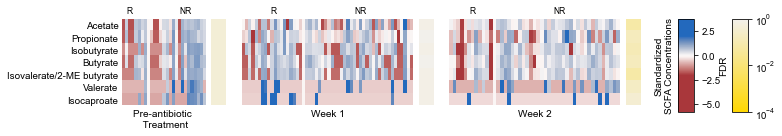

In [10]:
fig, ax = plt.subplots(1,8, gridspec_kw = {'width_ratios':[ratios['scfa'][0],0.5,0.15,
                                                           ratios['scfa'][1],0.5,0.15,ratios['scfa'][1],0.5]}, 
                       figsize = (7.5,2),
                      constrained_layout = False)
set_font_sizes(None, {'font': 10, 'axes_title': 10, 'axes_label': 10, 
                                          'xtick_label': 8.5, 'ytick_label': 8, 
                         'legend': 10, 'figure_title': 12})
ax_scfa = ax[[0,3,6]]
ax_side = ax[[1,4,7]]
ax_inv_bw = ax[[2,5]]
    
for axx in ax_inv_bw:
    axx.set_visible(False)

dat, outcomes = get_data('scfa', dl, dtype = 'data')
rownames = dat.columns.values[:-2]
fig, ax_scfa, ax_side, right, pos = plot_heatmap('scfa', rownames, fig, ax_scfa, ax_side, dl,
                                                         dtype = 'data', 
                                            figsize = 8*3.25, cmap_heat = 'vlag', cmap_sig = 'gold',
                                                 path_to_univariate_analysis = '/Users/jendawk/Dropbox (MIT)/C Diff Recurrence Paper/Analyses/univariate_analysis_control/',
                                                path_to_save_data = '/Users/jendawk/Dropbox (MIT)/C Diff Recurrence Paper/Rebuttal 2/GenFigure&AnalysesData/')

ax_scfa[0].axes.get_yaxis().set_visible(True)
ax_scfa[0].set_yticks(np.arange(len(rownames)))
# ax_scfa[0].set_yticklabels([dd.replace("/","/\n") for dd in rownames])
ax_scfa[0].set_yticklabels(rownames)
ax_scfa[0].tick_params(axis = 'y', length = 0)

arr_y = 0.19
arr_x = 1.05
set_font_sizes((10,5), {'font': 12, 'ytick_label': 10})
cbaxes = fig.add_axes([arr_x + 0.10, arr_y, 0.03, 0.65]) 
cb = fig.colorbar(right, cax = cbaxes)
cbaxes.set_ylabel('FDR')
cbaxes.yaxis.set_label_position("left")
# cbaxes.set_yticklabels(["$10^{-1}$","1"])
cbaxes.xaxis.set_label_position('top')

cbaxes2 = fig.add_axes([arr_x, arr_y, 0.03, 0.65]) 
cb2 = fig.colorbar(pos, cax = cbaxes2)
cbaxes2.set_ylabel('Standardized\nSCFA Concentrations')
cbaxes2.yaxis.set_label_position("left")
# cbaxes2.set_yticklabels(["","-2","0","2",""])
cbaxes2.xaxis.set_label_position('top')
# cbaxes2.yaxis.tick_left()
fig.savefig(path_to_save + 'supplemental_figures/FigS3_scfa.pdf',bbox_inches='tight')